# Diffusion Model

## Import libraries

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import uncertainties
import uncertainties.unumpy as unumpy
from uncertainties import ufloat
import uncertainties.umath
import random
from matplotlib.pyplot import subplots, show
from matplotlib import pyplot, pylab
from numpy import cov

- First we want to start out with these empty arrays for each new crystal. 
## *Do not run*  this line again until the plagioclase crystal has been run for all temperatures.

In [2]:
newDsr700 = []; newDsr750 = []; newDsr800 = []; newDsr850 = []; newDsr900 = []; newDsr950 = []
Time1 = []; Time2 = []; Time3 = []; Time4 = []; Time5 = []; Time6 = []
c700 = []; c750 = []; c800 = []; c850 = []; c900 = [] ;c950 = []
Co1 = []; Co2 = []; Co3 = []; Co4 = []; Co5 = []; Co6 = []

### Import Data using pandas, change 'df' for each grain - see Compiled St. Lucia Data (2) excel sheet
- Change the file name under `data` accordingly to your dataset. Also, look at `sheet_name` and determine which sheet you want to use
- Manipulate the `df` variable according to the excel spreadsheet. Hint: Take one less than the total rows you're analyzing. Take the comment out if you want confirm which rows/columns you're looking at
- Change the string names if necessary for the `SrUncert, Label, Sr1, length` according to your excel sheet

In [4]:
data = pd.read_excel(r'Compiled_St.Lucia_Data.xlsx', sheet_name = 'SL-1.4C') 
df = data.iloc[0:16] 
#print(df)
SrUncert = df['Sr Uncert']
Label = df['1.4C'].iloc[0]
Sr1 = df['Sr']
Sr1 = list(Sr1)
length = df['length'].iloc[0]
Srfull = df['Sr']
Srfull = list(Srfull)

### User input for temperature

In [81]:
Temp = input()
Temp = int(Temp)

 700


## Equilibrium conditions
- The gas constant `R` is in kj 
- The uncertainties package here is propogating the uncertainty of the dataset. Values for `w` and `c` taken form Blundy and Wood **ONE SIGMA**

In [82]:
R = .008314
An1 = df['An'].iloc[0]
Sr = df['Sr'].iloc[0]
Uncertainty = df['Sr Uncert'].iloc[0]
rim = uncertainties.ufloat(Sr, Uncertainty)
w = uncertainties.ufloat(26.7, 0.95)
c = uncertainties.ufloat(26.8, 0.6)
melt = rim / (uncertainties.umath.exp(((c-(w * (An1)))/(R*(Temp+273)))))
e = unumpy.nominal_values(melt)
f = unumpy.std_devs(melt)
melt1 = uncertainties.ufloat(e, f)

### Calculating Equilibrium Array
- `newDsr` defines the distribution coefficient from Blundy and Wood. 
- Since the uncertainty is propagated here, the end array must be split up into `newDsr1` and `Uncert` where `newDsr` has the nominal values for the equilibrium calculation and the `Uncert` has the uncertainties of those nominal values
- `newDsr1` is converted to a list
- Every line after converting `newDsr1` to a list is storing the values according to the temperatures so there is no overlap for each new temperature run

In [83]:
newDsr = []
for i in df['An']:
    Dsr = (melt1)*(uncertainties.umath.exp(((c-(w * (i)))/(R*(Temp+273)))))
    newDsr.append(Dsr)
newDsr1 = unumpy.nominal_values(newDsr)
Uncert = unumpy.std_devs(newDsr)
newDsr1 = list(newDsr1)
if Temp == 700:
    if newDsr1 not in newDsr700:
        newDsr700.append(newDsr1)
if Temp == 750:
    if newDsr1 not in newDsr750:
        newDsr750.append(newDsr1)
if Temp == 800:
    if newDsr1 not in newDsr800:
        newDsr800.append(newDsr1)
if Temp == 850:
    if newDsr1 not in newDsr850:
        newDsr850.append(newDsr1)
if Temp == 900:
    if newDsr1 not in newDsr900:
        newDsr900.append(newDsr1)
if Temp == 950:
    if newDsr1 not in newDsr950:
        newDsr950.append(newDsr1)

### Sr Diffusivity
- `j` is the activation energy defined by Zellmer by taking the average experimental values for a range of An content
- `D` is the array of Sr diffusivity values
- `DifSr` is calculated using equation *7* from Zellmer 1999: Dsr = 10$^-(4.1XAn +4.08)$ $e$(-3.22 *10 $^4$ / T)

In [84]:
An = df['An']
An = list(An)
j = 276
D = []
for i in An:
    DifSr = (((10**-(4.1*i + 4.08))*(np.exp((-(j/R))/(Temp+273)))))*10**12 #from Zellmer1999/Costa 2006
    D.append(DifSr)
D = list(D)
#print(D)

### Diffusion parameters
- `time1` will need to be manipulated by the user to determine best fit
- `A` is defined in the Costa 2003 paper 

In [103]:
time1 = 150000

In [104]:
L = length; Nx = len(An) - 1; x = np.linspace(0, L, Nx+1); dx = x[1]-x[0]; time = 3.15*10**7
T = (time1)*(time); Nt = 50; t = np.linspace(0, T, Nt+1); dt = t[1] - t[0]; dx= dx**2; ch = (dt/dx)/10
A = -26.1

### Diffusion Model
- Equation *7* from Costa 2003
- `test, test2, and f` are all 'dummy' variables to fill the Initial concentration array with the Initial and Boundary conditions form the Equilibrium calculation above

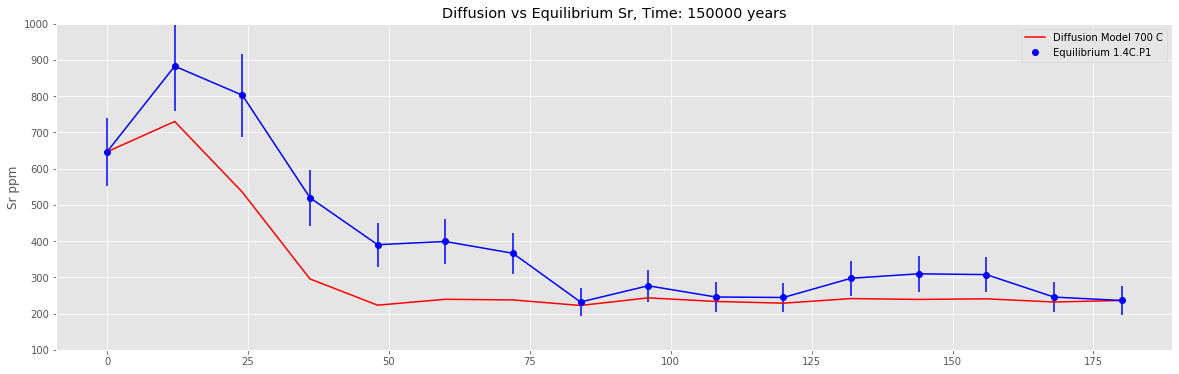

In [105]:
u = np.zeros(Nx+1); test = newDsr1[0]; test2 = newDsr1[-1]; f = np.zeros(len(An)-1); f.fill(test2); C = np.hstack((test, f)); C = list(C)
for n in range(0, Nt):
    for i in range(1, Nx):
        u[i] = C[i]+ ((D[i]*(C[i+1] - 2*C[i] + C[i-1])) + ((D[i+1]-D[i])*(C[i+1]-C[i])) 
                - (A/(R*(Temp+273)))*(D[i] * ((C[i+1]-C[i]) * (An[i+1]-An[i])) + C[i]*((D[i+1]-D[i])*(An[i+1]-An[i])) +
                             D[i]*C[i]*(An[i+1]-2*An[i]+An[i-1]))) * ch
    u[0] =C[0];  u[Nx] = C[-1]
    C, u = u, C
if Temp == 700:
    if C not in c700:
        c700.append(C)
if Temp == 750:
    if C not in c750:
        c750.append(C)
if Temp == 800:
    if C not in c800:
        c800.append(C)
if Temp == 850:
    if C not in c850:
        c850.append(C)
if Temp == 900:
    if C not in c900:
        c900.append(C)
if Temp == 950:
    if C not in c950:
        c950.append(C)
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(x, C, 'r', label = 'Diffusion Model '+str(Temp)+' C')
    ax1.plot(x, newDsr1, 'bo', label='Equilibrium '+str(Label))
    ax1.errorbar(x, newDsr1, yerr=Uncert, color = 'blue')
    ax1.set(ylabel='Sr ppm', title='Diffusion vs Equilibrium Sr, Time: ' +str(time1)+ ' years', ylim = (100,1000))
    ax1.legend(loc="upper right")
    fig.set_size_inches(20, 6)
    plt.show()

### Diffusion Model for Measured Sr
- Redefining variables for this model run, similar to the above
- `first, last, and filler` are all dummy variables again to set up boundary and initial conditions
- `Initial` is plotted to show the initial boundary and core conditions determined by user
- `last` should be manipulated by the user to determine the best fit for the model by playing the the average of the core points to get the best rim fit 

In [101]:
time2 = 12000

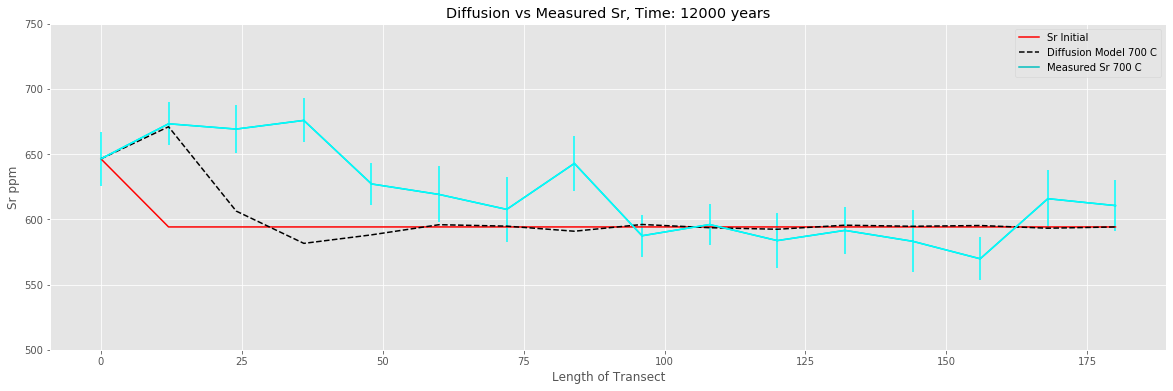

In [102]:
T1 = (time2)*(time); Nt1 = 50; t1 = np.linspace(0, T1, Nt1+1); dt1 = t1[1] - t1[0]; ch = (dt1/dx)/10
u1 = np.zeros(Nx+1); first = Sr1[0]; last = np.mean(Sr1[-5:])  
filler = np.zeros(len(An)-1); filler.fill(last); Initial = np.hstack((first, filler)); Initial = list(Initial)
C1 = np.hstack((first, filler));C1 = list(C1)
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    ax2.plot(x, Initial, 'r-', label = 'Sr Initial')
#print(C1)
for j in range(0, Nt1):
    for i in range(1, Nx):
        u1[i] = C1[i]+ ((D[i]*(C1[i+1] - 2*C1[i] + C1[i-1])) + ((D[i+1]-D[i])*(C1[i+1]-C1[i])) 
                - (A/(R*(Temp+273)))*(D[i] * ((C1[i+1]-C1[i]) * (An[i+1]-An[i])) + C1[i]*((D[i+1]-D[i])*(An[i+1]-An[i])) +
                                D[i]*C1[i]*(An[i+1]-2*An[i]+An[i-1]))) * ch
    u1[0] =C1[0];  u1[Nx] =C1[-1]  
    C1, u1 = u1, C1
if Temp == 700:
    if C1 not in Co1:
        Co1.append(C1)
if Temp == 750:
    if C1 not in Co2:
        Co2.append(C1)
if Temp == 800:
    if C1 not in Co3:
        Co3.append(C1)
if Temp == 850:
    if C1 not in Co4:
        Co4.append(C1)
if Temp == 900:
    if C1 not in Co5:
        Co5.append(C1)
if Temp == 950:
    if C1 not in Co6:
        Co6.append(C1)
        
if Temp == 700:
    if time2 not in Time1:
        Time1=[]; Time1.append(time2)
if Temp == 750:
    if time2 not in Time2:
        Time2=[]; Time2.append(time2)
if Temp == 800:
    if time2 not in Time3:
        Time3=[]; Time3.append(time2)
if Temp == 850:
    if time2 not in Time4:
        Time4=[]; Time4.append(time2)
if Temp == 900:
    if time2 not in Time5:
        Time5=[]; Time5.append(time2)
if Temp == 950:
    if time2 not in Time6:
        Time6=[]; Time6.append(time2)
        
with plt.style.context('ggplot'):
    ax2.plot(x, C1, 'k--', label = 'Diffusion Model '+str(Temp)+' C'); ax2.plot(x, Sr1, 'c', label = 'Measured Sr '+str(Temp)+' C');ax2.errorbar(x, Sr1, yerr=SrUncert, color = 'cyan')
    ax2.set(ylabel='Sr ppm',xlabel = 'Length of Transect',title = 'Diffusion vs Measured Sr, Time: ' +str(time2)+ ' years', ylim = (500,750))
    ax2.legend(loc="upper right"); fig.set_size_inches(20, 6);plt.pause(0.1)
#print(C1)

### Plotting Equilibrium and Measured models together

<Figure size 432x288 with 0 Axes>

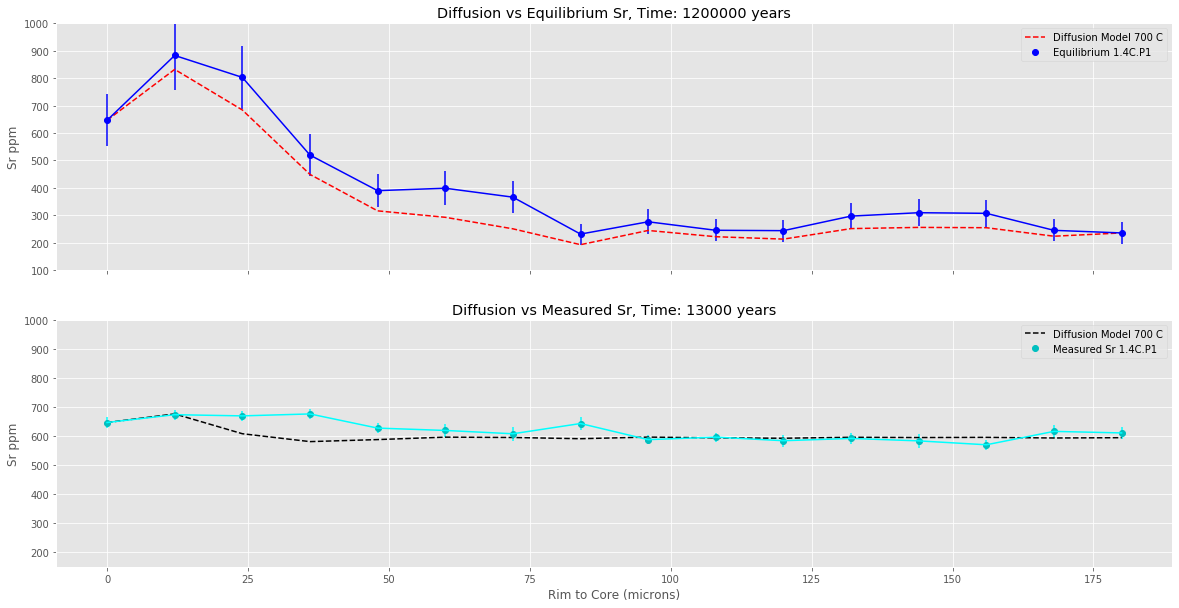

In [17]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(x, C, 'r--', label = 'Diffusion Model '+str(Temp)+' C')
    ax1.plot(x, newDsr1, 'bo', label='Equilibrium '+str(Label))
    ax1.errorbar(x, newDsr1, yerr=Uncert, color = 'blue')
    ax1.set(ylabel='Sr ppm', title='Diffusion vs Equilibrium Sr, Time: ' +str(time1)+ ' years', ylim = (100,1000))

    ax1.legend(loc="upper right")
    ax2.plot(x, C1, 'k--', label = 'Diffusion Model '+str(Temp)+' C')
    ax2.plot(x, Sr1, 'co', label = 'Measured Sr '+str(Label))
    ax2.errorbar(x, Sr1, yerr=SrUncert, color = 'cyan')

    ax2.set(ylabel='Sr ppm',xlabel = 'Rim to Core (microns)',title = 'Diffusion vs Measured Sr, Time: ' +str(time2)+ ' years', ylim = (150,1000))
    ax2.legend(loc="upper right")
    fig.set_size_inches(20, 10)
    fig.savefig('SL-'+str(Label)+ '_'+str(Temp)+'.png')

### Plotting Plag residence time vs Temperature for Measured diffusion models
- Don't run this until all times and temperatures are run

<Figure size 432x288 with 0 Axes>

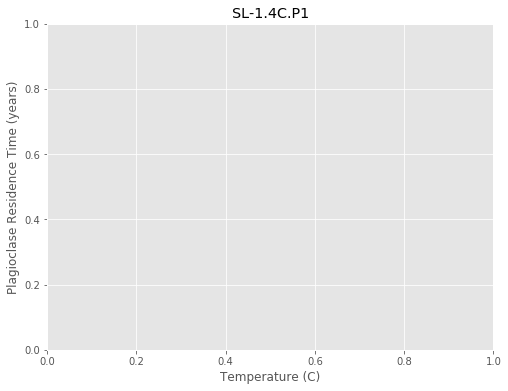

In [75]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    fig, ax = subplots()
    Temp7 = [700,750,800,850,900,950]
    time7 = [Time1,Time2, Time3, Time4,Time5,Time6]
    plt.plot(Temp7, time7, 'b')
    ax.set_xlabel("Temperature (C)")
    ax.set_title('SL-'+str(Label))
    ax.set_ylabel("Time")
    ax.set(ylabel="Plagioclase Residence Time (years)",xlabel = "Temperature (C)",title = 'SL-'+str(Label))
    fig.set_size_inches(8, 6)
    fig.savefig('SL-'+str(Label)+ 'ResidenceTimevT.png')

### Do not run until done with every temperature for this Crystal
- This is where that first line after importing modules comes into play
- Each equilibrium array at each temperature is saved, so after each temperature is run through, this code can be run

<Figure size 432x288 with 0 Axes>

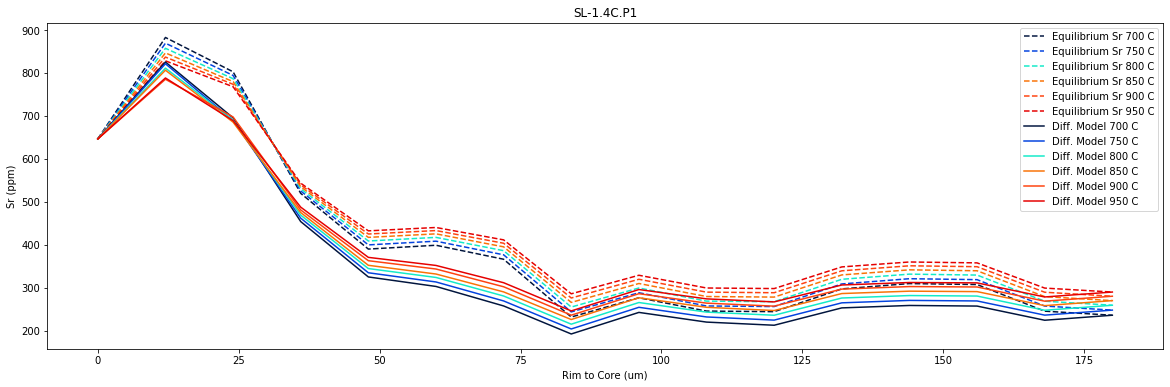

In [162]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    fig, ax = subplots()
    plt.plot(x, newDsr700[0], 'xkcd:navy', linestyle='dashed', label = 'Equilibrium Sr 700 C' )
    plt.plot(x, newDsr750[0], 'xkcd:blue', linestyle='dashed', label = 'Equilibrium Sr 750 C' )
    plt.plot(x, newDsr800[0], 'xkcd:aqua', linestyle='dashed', label = 'Equilibrium Sr 800 C' )
    plt.plot(x, newDsr850[0], 'xkcd:orange', linestyle='dashed', label = 'Equilibrium Sr 850 C' )
    plt.plot(x, newDsr900[0], 'xkcd:orangered', linestyle='dashed', label = 'Equilibrium Sr 900 C' )
    plt.plot(x, newDsr950[0], 'xkcd:red', linestyle='dashed', label = 'Equilibrium Sr 950 C' )
    plt.plot(x, c700[0], 'xkcd:navy', label = 'Diff. Model 700 C' )
    plt.plot(x, c750[0], 'xkcd:blue', label = 'Diff. Model 750 C' )
    plt.plot(x, c800[0], 'xkcd:aqua', label = 'Diff. Model 800 C' )
    plt.plot(x, c850[0], 'xkcd:orange', label = 'Diff. Model 850 C' )
    plt.plot(x, c900[0], 'xkcd:orangered', label = 'Diff. Model 900 C' )
    plt.plot(x, c950[0], 'xkcd:red', label = 'Diff. Model 950 C' )
    ax.set_xlabel("Rim to Core (um)")
    ax.set_title('SL-'+str(Label))
    ax.set_ylabel("Sr (ppm)")
    plt.legend(loc="upper right")
    fig.set_size_inches(20,6)

<Figure size 432x288 with 0 Axes>

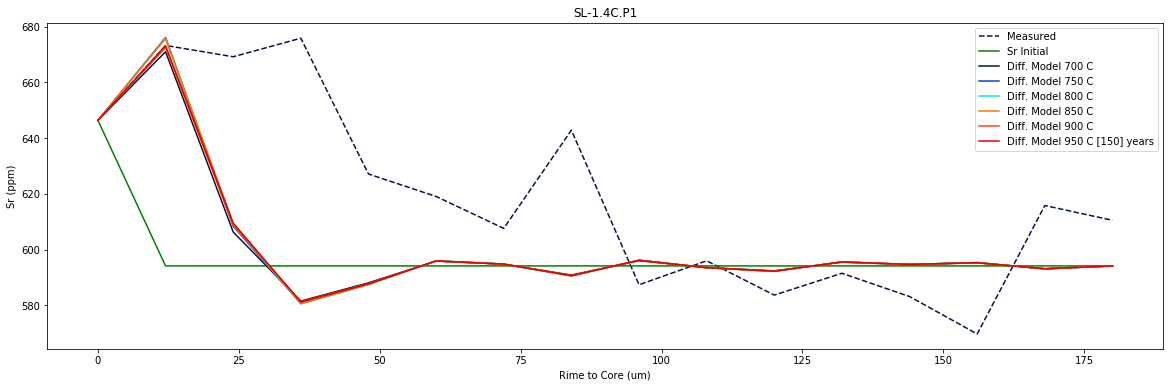

In [170]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    fig, ax = subplots()
    plt.plot(x, Sr1, 'xkcd:navy', linestyle='dashed', label = 'Measured' )
    plt.plot(x, Initial, 'g-', label = 'Sr Initial')
    plt.plot(x, Co1[0], 'xkcd:navy', label = 'Diff. Model 700 C' )
    plt.plot(x, Co2[0], 'xkcd:blue', label = 'Diff. Model 750 C' )
    plt.plot(x, Co3[0], 'xkcd:aqua', label = 'Diff. Model 800 C' )
    plt.plot(x, Co4[0], 'xkcd:orange', label = 'Diff. Model 850 C' )
    plt.plot(x, Co5[0], 'xkcd:orangered', label = 'Diff. Model 900 C' )
    plt.plot(x, Co6[0], 'xkcd:red', label = 'Diff. Model 950 C ' + str(Time6) + ' years' )
    ax.set_xlabel("Rime to Core (um)")
    ax.set_title('SL-'+str(Label))
    ax.set_ylabel("Sr (ppm)")
    plt.legend(loc="upper right")
    fig.set_size_inches(20,6)